In [203]:
import json

txs = []
tx_id = 0
with open('Workloads/1m-net_5k-tx_1s-bt/trace.txt') as f:
    for line in f:
        line = line.strip().split()
        time, size = float(line[0]), float(line[2])

        if tx_id == 0:
            start_time = time
        
        tx = {
            'node': 0,
            'id': tx_id,
            'timestamp': time - start_time ,
            'size': size
        }
        txs.append(tx)
        tx_id += 1

min_time = min(txs, key=lambda x:x['timestamp'])['timestamp']

with open('Workloads/1m-net_5k-tx_1s-bt.json','w') as f:
    json.dump(txs, f, indent=4)

In [88]:
def plot(axes, fig, sizes, blocktimes, mean_latency_per_block, runtime, throughput_blocks, throughput_trace):
    axes = axes.ravel()
    # fig.suptitle("Simulation results")

    fig.set_figwidth(10)
    fig.set_figheight(5)

    lines_parms = {'markersize':3, 'linewidth':1}

    for ax in axes:
        ax.grid(alpha=.5)

    ax = axes[0]
    ax.plot([x for x in sizes], 'b--x', **lines_parms)
    ax.set_ylabel("No. Tx")
    ax.set_xlabel("Blocks")
    ax.set_title("Transactions per block")


    ax = axes[1]
    ax.plot(blocktimes[0:], 'g--x', **lines_parms)
    ax.set_ylabel("Time (S)")
    ax.set_xlabel("Blocks")
    ax.set_title("Inter Block Time")

    ax = axes[2]
    ax.plot([round(x,3) for x in mean_latency_per_block], 'r--x', **lines_parms)
    ax.set_ylabel("Latency (S)")
    ax.set_xlabel("Blocks")
    ax.set_title("Average Transaction Latency per block")

    axes[3].set_axis_off()

    ax = inset_axes(axes[3], width="35%", height="100%", loc='upper left', borderpad=0)

    ax.bar(1, runtime, zorder=2)
    ax.set_xlim(0,2)
    ax.set_xticks(ticks=[1], labels=['Runtime'])
    ax.set_ylabel('Time (S)')
    ax.grid(alpha=.5)
    ax.set_title("System runtime")

    ax = inset_axes(axes[3], width="50%", height="100%", loc='right', borderpad=0)

    # Plotting the second bar plot on the secondary axis
    ax.bar(1, throughput_blocks, zorder=2)
    ax.set_xlim(0,3)
    ax.bar(2, throughput_trace, zorder=2)
    ax.set_ylabel('Throughput (Tx/s)')
    ax.set_xticks(ticks=[1,2], labels=['Achieved', 'Workload'])
    ax.grid(alpha=.5)
    ax.set_title("System Throughput")

    plt.tight_layout()
    # # plt.savefig("figures/res.pdf", format='pdf')

In [98]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import json
import statistics as st

def get_sim_data():
    with open('output/blockchain.json', 'r') as f:
        data = json.load(f)

    blockchain = data['0'][1:]
    sizes = [len(x['tx']) for x in blockchain]
    blocktimes = [bj['timestamp'] - bi['timestamp'] for bi, bj in zip(blockchain[:-1], blockchain[1:])]
    mean_latency_per_block = []

    for block in blockchain:
        ts = block['timestamp']
        mean_latency_per_block.append(
            st.mean([ts-x[1] for x in block['tx']])
        )
            
    runtime = blockchain[-1]['timestamp']

    throughput_blocks = sum([len(b['tx']) for b in blockchain]) / runtime

    transactions_per_block = [[x[1] for x in block['tx']] for block in blockchain]
    transactions = []
    for tx_list in transactions_per_block:
        transactions += tx_list

    throughput_trace = len(transactions) / transactions[-1]

    return {
        'tx_per_block': sizes,
        'blocktimes': blocktimes,
        'mean_latency_per_block': mean_latency_per_block,
        'runtime': runtime,
        'tp_system': throughput_blocks,
        'tp_trace': throughput_trace
    }

def get_data_tm(dir_name):
    def calculate_tx_per_second(file_path):
        seconds = []
        with open(file_path, 'r') as file:
            for line in file:
                try:
                    # Split the line and extract the timestamp
                    timestamp = line.strip().split('\t')[0]
                    # Convert timestamp to integer to group transactions by second
                    second = int(float(timestamp))
                    seconds.append(second)
                except (IndexError, ValueError):
                    continue
        
        tx_count = {}
        for sec in range(min(seconds), max(seconds)):
            tx_count[sec] = len([x for x in seconds if x == sec])

        return tx_count
    
    blocks_path = f"Workloads/{dir_name}/blocks.txt"
    block_times_path = f"Workloads/{dir_name}/block_times.txt"
    trace_path = f"Workloads/{dir_name}/trace.txt"

    sizes, txs, timestamps = [], [], []
    with open(blocks_path, 'r') as f:
        for line in f:
            size, tx, timestamp = line.strip().split('\t')
            sizes.append(int(size))
            txs.append(int(tx))
            timestamps.append(float(timestamp))

    blocktimes_t = []
    for cur, next in zip(timestamps[:-1], timestamps[1:]):
        blocktimes_t.append(next-cur)

    blocktimes = []
    with open(block_times_path, 'r') as f:
        for line in f:
            times = line.strip()
            blocktimes.append(float(times))


    latencies_per_block = {}
    with open(trace_path, 'r') as f:
        for line in f:
            tx = line.strip().split('\t')
            block, latency = int(tx[-2]), float(tx[-1])
            if block > 3:
                latencies_per_block[block] = latencies_per_block.get(block, []) + [latency]

    mean_latency_per_block = [st.mean(latencies) for latencies in latencies_per_block.values()]

    # Usage
    tx_per_sec = calculate_tx_per_second(trace_path)

    runtime = timestamps[-1] - timestamps[0]

    throughput_blocks = sum(txs) / runtime

    throughput_trace = st.mean(tx_per_sec.values())

    return {
        'tx_per_block': txs,
        'blocktimes': blocktimes,
        'mean_latency_per_block': mean_latency_per_block,
        'runtime': runtime,
        'tp_system': throughput_blocks,
        'tp_trace': throughput_trace
    }

C:\Users\George\AppData\Local\Temp\ipykernel_12760\2369672218.py:70: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


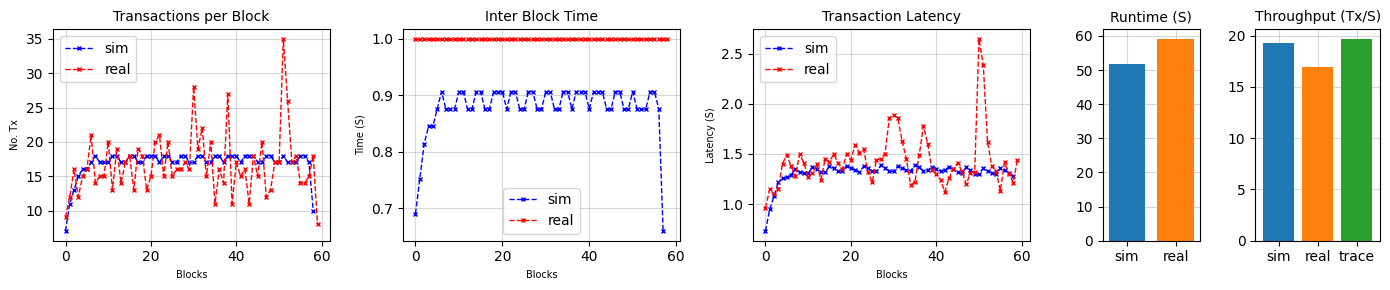

In [212]:
sim_data, tm_data = get_sim_data(), get_data_tm('1m-net_5k-tx_1s-bt')

fig, axes = plt.subplots(1,4)

axes = axes.ravel()
# fig.suptitle("Simulation results")

fig.set_figwidth(14)
fig.set_figheight(3)

lines_parms = {'markersize':3, 'linewidth':1}

for ax in axes:
    ax.grid(alpha=.5)

ax = axes[0]

ax.plot([x for x in sim_data['tx_per_block']], 'b--x', **lines_parms, label='sim')
ax.plot([x for x in tm_data['tx_per_block']], 'r--x', **lines_parms, label='real')
ax.legend()
ax.set_ylabel("No. Tx", fontsize=7)
ax.set_xlabel("Blocks", fontsize=7)
ax.set_title("Transactions per Block", fontsize=10)


ax = axes[1]

ax.plot([x for x in sim_data['blocktimes']], 'b--x', **lines_parms, label='sim')
ax.plot([x for x in tm_data['blocktimes']], 'r--x', **lines_parms, label='real')
ax.legend()
ax.set_ylabel("Time (S)", fontsize=7)
ax.set_xlabel("Blocks", fontsize=7)
ax.set_title("Inter Block Time", fontsize=10)

ax = axes[2]

ax.plot([x for x in sim_data['mean_latency_per_block']], 'b--x', **lines_parms, label='sim')
ax.plot([x for x in tm_data['mean_latency_per_block']], 'r--x', **lines_parms, label='real')
ax.legend()
ax.set_ylabel("Latency (S)", fontsize=7)
ax.set_xlabel("Blocks", fontsize=7)
ax.set_title("Transaction Latency", fontsize=10)

axes[3].set_axis_off()

ax = inset_axes(axes[3], width="35%", height="100%", loc='upper left', borderpad=0)

ax.bar(.5, sim_data['runtime'], width=.75, zorder=2)
ax.bar(1.5, tm_data['runtime'], width=.75, zorder=2)
ax.set_xlim(0,2)
ax.set_xticks(ticks=[.5, 1.5], labels=['sim', 'real'])
# ax.set_ylabel('Time (S)', fontsize=6)
ax.grid(alpha=.5)
ax.set_title("Runtime (S)", fontsize=10)

ax = inset_axes(axes[3], width="45%", height="100%", loc='right', borderpad=0)

# Plotting the second bar plot on the secondary axis
ax.bar(1, sim_data['tp_system'], zorder=2)
ax.bar(2, tm_data['tp_system'], zorder=2)
ax.bar(3, sim_data['tp_trace'], zorder=2)
ax.set_xticks(ticks=[1,2,3], labels=['sim', 'real', 'trace'])

# ax.set_ylabel('Throughput (Tx/s)', fontsize=6)
ax.set_xlim(0.4, 3.6)
ax.grid(alpha=.5)

ax.set_title("Throughput (Tx/S)", fontsize=10)

plt.tight_layout()
# # plt.savefig("figures/res.pdf", format='pdf')
